In [25]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from tqdm import tqdm

## Model:

$$\large f(x) = a e^{-b x} + c$$

* $a + c$ - intercept
* $b$ (or $\lambda$) - rate; the higher the value, the faster peak amplitude decays
* $c$ - constant to "shift" the values

In [26]:
class ExponentialDecay:
    """
    Exponential decay model.
    
    Fits an exponental model a*exp(-b*x)+c using non-linear least squares.
    
    Parameters
    ----------
    n_clicks : int, default=None
        Amount of expected clicks or time points.
        
    Attributes
    ----------
    params : array of shape (3,)
        Array with the estimated coefficients after model fit.
        
    cov : array of shape (3,3)
        The estimated covariance of coefficients.
    """
    
    def __init__(self, n_clicks=None):
        assert type(n_clicks) == int, "Frequency should be a positive integer"
        self.n_clicks = n_clicks
    
    
    def formula(self, x, a, b, c):
        """
        Model that will be used for fitting.
        
        Parameters
        ----------
        x : array
            Click order.
        
        a : float
            Intercept.
        
        b : float
            Rate of change.
            
        c : float
            Constant term to "shift" along y-axis.
        
        Returns
        -------
        f(x) : array
            Fitted values.
        """
        
        return a * np.exp(-b * x) + c
    
    
    def fit(self, xdata, ydata):
        """
        Fit the exponential decay model.
        
        Parameters
        ----------
        xdata : array-like of shape
            Array of click orders.
            
        ydata : array-like of shape
            Array of values to predict (e.g. peak amplitude).
        
        Returns
        -------
        self : returns an instance of self.        
        """
        
        
        self.params, self.cov = curve_fit(
            f=self.formula, 
            xdata=xdata, 
            ydata=ydata,
            maxfev=2500)
        
        return self
        
        
    def predict(self, xfit=None):
        """
        Make a prediction using estimated parameters.
        
        Parameters
        ----------
        xfit : array-like, default=None
            Array of x values to fit a model on. 
            If skipped, will be set to 100 linearly interpolated 
            values from 1 to n_clicks.
            
        Returns
        -------
        f(x) : array
            Fitted values.
        """
        
        if xfit is None:
            xfit = np.linspace(1, self.n_clicks, 100)
        return self.formula(
            xfit, 
            *self.params)    
        
    
    def get_params(self):
        """
        Get the estimated coefficients after model fit.
        """
        
        return self.params
    
    
    def get_cov(self):
        """
        Get the estimated covariance of coefficients after model fit.
        """
        
        return self.cov
    
    
    def plot_fit(self, xdata, ydata):
        """
        Make a plot of fit for visual diagnostic.
        
        Parameters
        ----------
        xdata : array-like of shape 
            Array of click orders that was used to fit the model.
            
        ydata : array-like of shape
            Array of values to predict (e.g. peak amplitude)
            that was used to fit a model.
        """

        
        xfit = np.linspace(1, self.n_clicks, 100)
        yfitted = self.predict(xfit)
        plt.figure()
        plt.plot(
            xfit, yfitted, 'r-', 
            label=f"fitted data, rate={self.params[1]:.2f}")
        plt.scatter(
            xdata, ydata, 
            label="actual data")
        plt.legend()
        plt.xlabel(xdata.name, fontsize=12)
        plt.ylabel(ydata.name, fontsize=12)
        plt.title('Exponential Decay Model', fontsize=14)
        plt.show()

In [27]:
avrec_cl_raw = pd.read_csv("../../Data_new/AVRECPeakCL.csv")
avrec_cl_raw.head()

,Group,Animal,Layer,Measurement,ClickFreq,OrderofClick,PeakAmp,PeakLat,RMS
0,KIC,KIC02,All,preCL_1,2,1,0.002204,37.0,0.000936
1,KIC,KIC02,All,preCL_1,2,2,0.001448,37.0,0.000807
2,KIC,KIC02,All,CL_1,2,1,0.003571,38.0,0.001765
3,KIC,KIC02,All,CL_1,2,2,0.003807,40.0,0.001612
4,KIC,KIC02,All,CL_2,2,1,0.003029,36.0,0.001451


In [28]:
# keep only 3 measurements - before lazer, after lazer 1, after lazer 2
cndtn = avrec_cl_raw["Measurement"].isin(["preCL_1", "CL_1", "CL_2"])
avrec_cl = avrec_cl_raw[cndtn].copy()

# rename to pre/post lazer
avrec_cl['Measurement'] = avrec_cl['Measurement'].apply(
    lambda x: "preLaser" if x == 'preCL_1' else "postLaser")

# average post measurements by Animal
avrec_cl = avrec_cl.groupby(
    by=['Group', 'Animal', 'Layer', 'Measurement', 'ClickFreq', 'OrderofClick'], 
    as_index=False)\
    .agg({'PeakAmp': 'mean', 'RMS': 'mean'})

# # average by Group
# avrec_cl = avrec_cl.groupby(
#     by=['Group', 'Layer', 'Measurement', 'ClickFreq', 'OrderofClick'], 
#     as_index=False)\
#     .agg({'PeakAmp': 'mean', 'RMS': 'mean'})

# Peak Amplitude

In [29]:
# dictionary that will hold all the estimated cofficients 
# in a nested way:
# {freq: {layer: {group: {pre_laser: [coefs], post_laser: [coefs]}}}
total_params = {} 

## 5 Hz


==Model parameters for group KIC:==
postLaser: intercept=0.002, rate=1.28, const=0.001
preLaser: intercept=0.002, rate=1.18, const=0.001


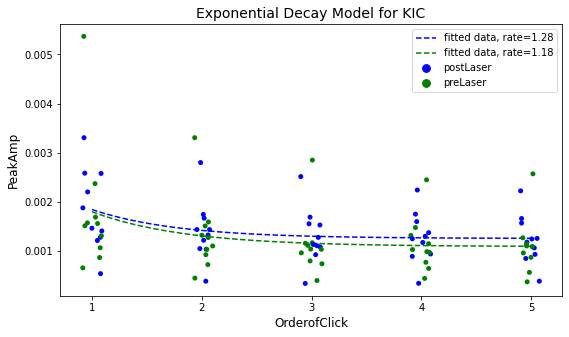


==Model parameters for group KIT:==
postLaser: intercept=0.001, rate=1.05, const=0.001
preLaser: intercept=0.001, rate=1.32, const=0.001


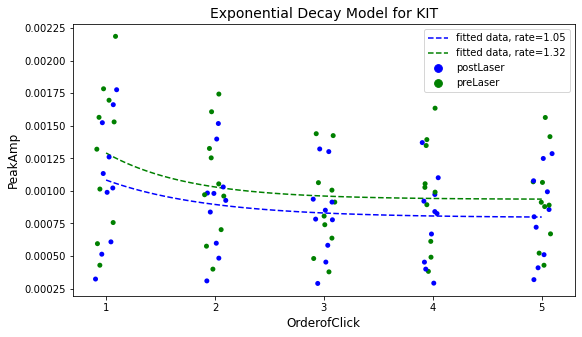


==Model parameters for group KIV:==
postLaser: intercept=0.002, rate=1.13, const=0.001
preLaser: intercept=0.002, rate=0.95, const=0.001


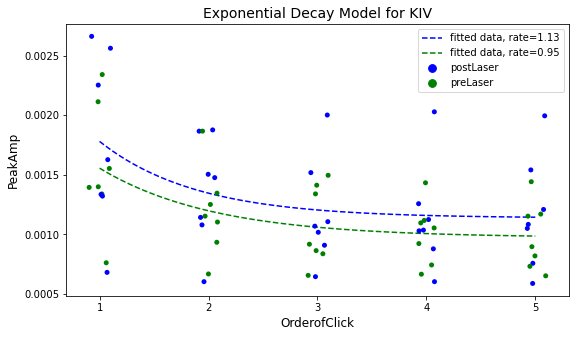

In [30]:
freq = 5
layer = "All"

# set dict keys
if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

# model init
exp_decay_model = ExponentialDecay(n_clicks=freq)

# data filtering
cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    # add dict key
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    # data filtering
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"\n==Model parameters for group {group}:==")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        # add dict key        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['PeakAmp']
        
        # fit the model
        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        # prediction for plot
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        # resulted parameters
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params
        
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.stripplot(
        data=temp_data, x='OrderofClick', y='PeakAmp', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit-1, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit-1, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()

## 10 Hz


==Model parameters for group KIC:==
postLaser: intercept=0.006, rate=1.88, const=0.001
preLaser: intercept=0.006, rate=1.89, const=0.001


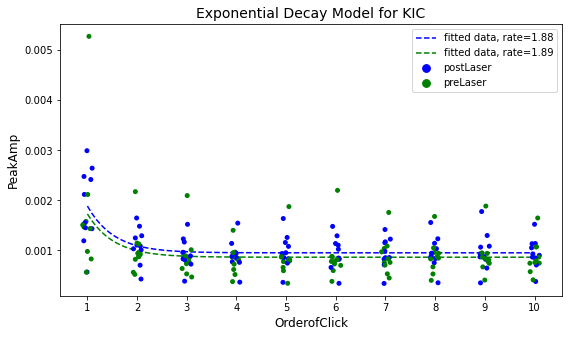


==Model parameters for group KIT:==
postLaser: intercept=0.002, rate=1.59, const=0.001
preLaser: intercept=0.004, rate=2.10, const=0.001


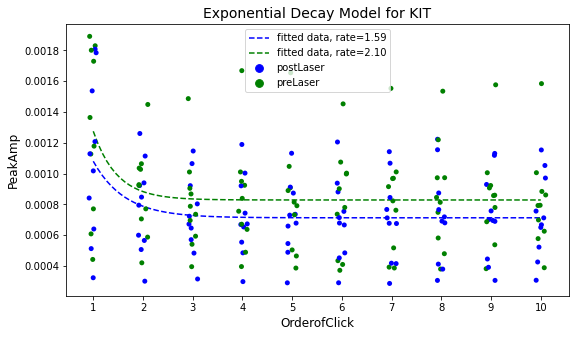


==Model parameters for group KIV:==
postLaser: intercept=0.003, rate=1.54, const=0.001
preLaser: intercept=0.003, rate=1.32, const=0.001


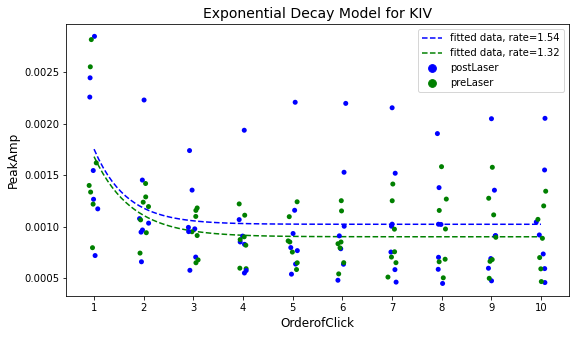

In [32]:
freq = 10
layer = "All"

# set dict keys
if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

# model init
exp_decay_model = ExponentialDecay(n_clicks=freq)

# data filtering
cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    # add dict key
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    # data filtering
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"\n==Model parameters for group {group}:==")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        # add dict key        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['PeakAmp']
        
        # fit the model
        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        # prediction for plot
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        # resulted parameters
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params
        
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.stripplot(
        data=temp_data, x='OrderofClick', y='PeakAmp', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit-1, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit-1, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()

In [33]:
pprint.pprint(total_params)

{5: {'All': {'KIC': {'postLaser': array([2.10924578e-03, 1.27868542e+00, 1.25948555e-03]),
                     'preLaser': array([2.30283100e-03, 1.18020979e+00, 1.09478884e-03])},
             'KIT': {'postLaser': array([8.24843871e-04, 1.05067353e+00, 7.94830258e-04]),
                     'preLaser': array([1.33329336e-03, 1.32023092e+00, 9.35045649e-04])},
             'KIV': {'postLaser': array([0.00198086, 1.12532302, 0.00113687]),
                     'preLaser': array([0.00150775, 0.95092111, 0.00097282])}}},
 10: {'All': {'KIC': {'postLaser': array([6.12289517e-03, 1.88096640e+00, 9.52639157e-04]),
                      'preLaser': array([5.73670826e-03, 1.89380797e+00, 8.64910261e-04])},
              'KIT': {'postLaser': array([1.79761316e-03, 1.58870562e+00, 7.12905377e-04]),
                      'preLaser': array([3.65186624e-03, 2.10219132e+00, 8.28665423e-04])},
              'KIV': {'postLaser': array([3.39950370e-03, 1.53964167e+00, 1.02364574e-03]),
                

# RMS

## 5 Hz

Model parameters for group KIC:
postLaser: intercept=0.006, rate=3.38, const=0.001
preLaser: intercept=0.001, rate=1.53, const=0.001


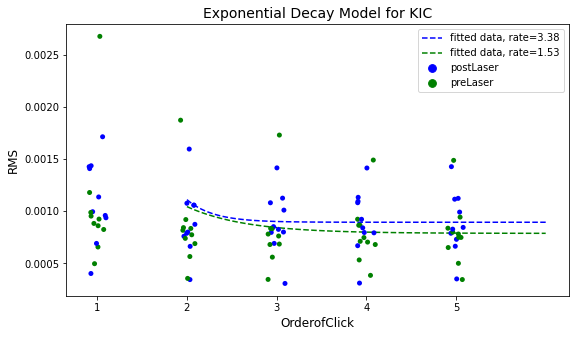

Model parameters for group KIT:
postLaser: intercept=0.000, rate=1.10, const=0.001
preLaser: intercept=0.001, rate=2.00, const=0.001


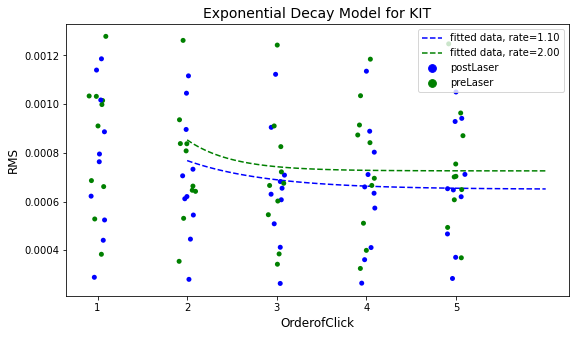

Model parameters for group KIV:
postLaser: intercept=0.002, rate=1.83, const=0.001
preLaser: intercept=0.001, rate=1.32, const=0.001


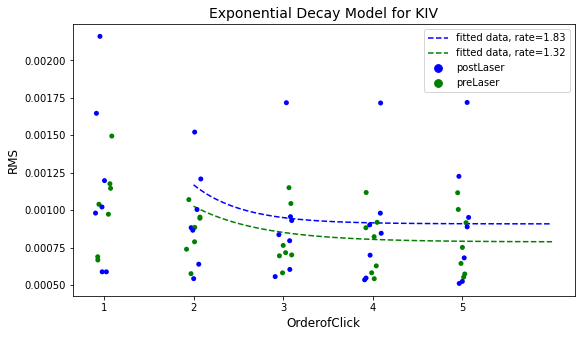

In [23]:
freq = 5
layer = "All"

if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

exp_decay_model = ExponentialDecay(n_clicks=freq)

cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"Model parameters for group {group}:")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['RMS']

        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params.round(3)
        
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.stripplot(
        data=temp_data, x='OrderofClick', y='RMS', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()

## 10 Hz

Model parameters for group KIC:
postLaser: intercept=0.002, rate=1.73, const=0.001
preLaser: intercept=0.002, rate=1.53, const=0.001


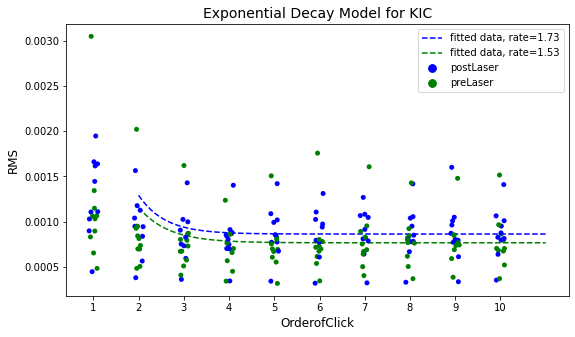

Model parameters for group KIT:
postLaser: intercept=0.000, rate=1.13, const=0.001
preLaser: intercept=0.001, rate=1.53, const=0.001


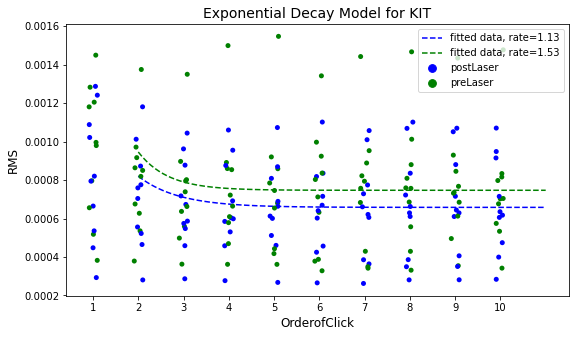

Model parameters for group KIV:
postLaser: intercept=0.002, rate=1.77, const=0.001
preLaser: intercept=0.001, rate=1.11, const=0.001


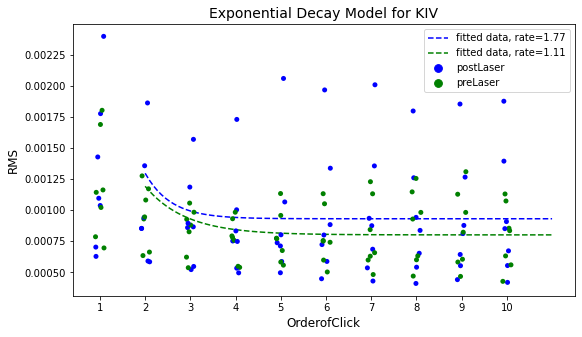

In [22]:
freq = 10
layer = "All"

if freq not in total_params.keys():
    total_params[freq] = dict()

if layer not in total_params[freq].keys():
    total_params[freq][layer] = dict()

exp_decay_model = ExponentialDecay(n_clicks=freq)

cndtn = (avrec_cl["Layer"] == layer) & (avrec_cl["ClickFreq"] == freq)
model_data = avrec_cl[cndtn]

for group in model_data['Group'].unique():
    
    if group not in total_params[freq][layer].keys():
        total_params[freq][layer][group] = dict()
    
    temp_data = model_data[model_data['Group'] == group]
    
    print(f"Model parameters for group {group}:")
    
    for msrmnt in temp_data['Measurement'].unique():
        
        if msrmnt not in total_params[freq][layer][group].keys():
            total_params[freq][layer][group][msrmnt] = []

        xdata = temp_data[temp_data['Measurement'] == msrmnt]['OrderofClick']
        ydata = temp_data[temp_data['Measurement'] == msrmnt]['RMS']

        exp_decay_model.fit(
            xdata=xdata,
            ydata=ydata)
        
        xfit = np.linspace(1, freq, 100)
        yfitted = exp_decay_model.predict(xfit=xfit)
        params = exp_decay_model.params
        total_params[freq][layer][group][msrmnt] = params.round(3)
        
        if msrmnt == 'postLaser':
            yfitted_post = yfitted
            params_post = params
        else:
            yfitted_pre = yfitted
            params_pre = params
            
        print(f"{msrmnt}: intercept={params[0]:.3f}, rate={params[1]:.2f}, const={params[2]:.3f}")
        

    plt.figure(figsize=(9,5))
    sns.stripplot(
        data=temp_data, x='OrderofClick', y='RMS', 
        hue='Measurement',
        palette=["b", "g"]
    )
    plt.plot(
        xfit, yfitted_post, 'b--', 
        label=f"fitted data, rate={params_post[1]:.2f}"
    )
    plt.plot(
        xfit, yfitted_pre, 'g--', 
        label=f"fitted data, rate={params_pre[1]:.2f}"
    )
    plt.xlabel(xdata.name, fontsize=12)
    plt.ylabel(ydata.name, fontsize=12)
    plt.title(f'Exponential Decay Model for {group}', fontsize=14)
    plt.legend()
    plt.show()